###### CSCE 320 :: Principles of Data Science ::Texas A&M University :: Fall 2020


# Group Project: Analysis of Election Data over Time for the purpose of finding the Optimal set of Training Data



Members: Matthew Spence, Adrian Shi, Marcel Theo, Michael Chacko

### Major Question:
What chronological subset of training data produces the most accurate election forecasting models?

### Purpose:
The outcomes of presidential elections shape U.S. government policy, which affects the lives of every American. We hope to determine if a predictive model generated from U.S. polling data is more or less accurate than historical data. 
Potential beneficiaries of this project are U.S. allies or businesses looking to predict the types of policies that will be implemented (which can affect their business)

### Method:
We intend to train multiple machine learning models of the same type on different subsets of training data. Each model will be trained on a chronologically continuous subset of election related data ending in 2016, and starting in each election year after 1936, ie 1936-2016, 1940-2016, 1944-2016...2012-2016. We will then compare the predictions of the various models to the actual outcome of the 2020 election, and see which is the most accurate. 
 
### Getting started: 
First we need to gather our data and clean it. Our datasets are as follows, and are divided up into pre-election data and post-election data. 
post-election: 
Popular Vote in U.S. Elections (Statista)
Historical Electoral Vote (Data Galore)
Binary Election outcome (Manually input)

pr-election data: 
Historic head to head polling data (Gallup)
Incumbent approval ratings (Gallup)
Past electoral votes by state (Electoral-Vote.com)
Government Approval Ratings (Pew Research)
Incumbency (Manually input)
Previous President's Political Party (Manually input)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

#
# Import data for reference. This is all combined into CleanedData later.
#

elections = pd.read_csv("CSV/elections-1900-to-2012.csv", encoding="utf-8") 
electoralVotes = pd.read_csv("CSV/electoral_votes.csv", encoding="utf-8") 
approvalRatings = pd.read_csv("CSV/incumbency_approval_ratings.csv", encoding="utf-8") 
popularVotes = pd.read_csv("CSV/popular_votes.csv", encoding="utf-8") 
trustRating = pd.read_csv("CSV/trust_rating.csv", encoding="utf-8")

#
# The data above was combined into a single CSV, imported as CleanedData.
#

CleanedData = pd.read_csv("CSV/cleaned_data.csv", encoding="utf-8")

#
# Change percentages in CleanedData to decimal form.
#

CleanedData['poll_d'] = CleanedData['poll_d'].str.rstrip('%').astype('float') / 100.0
CleanedData['poll_r'] = CleanedData['poll_r'].str.rstrip('%').astype('float') / 100.0
CleanedData['gdp_percent'] = CleanedData['gdp_percent'].str.rstrip('%').astype('float') / 100.0
CleanedData['electoral_r_percent'] = CleanedData['electoral_r_percent'].str.rstrip('%').astype('float') / 100.0
CleanedData['electoral_d_percent'] = CleanedData['electoral_d_percent'].str.rstrip('%').astype('float') / 100.0
CleanedData['popular_d_percent'] = CleanedData['popular_d_percent'].str.rstrip('%').astype('float') / 100.0
CleanedData['popular_r_percent'] = CleanedData['popular_r_percent'].str.rstrip('%').astype('float') / 100.0

#
# Put the CleanedData into a DataFrame called data.
#

data = pd.DataFrame(CleanedData)
data.head()

,year,electoral_d,electoral_r,total_electoral,electoral_d_percent,electoral_r_percent,popular_d,popular_r,popular_d_percent,popular_r_percent,poll_d,poll_r,incumbent,incumbent_won,incumbent_approval,trust,gdp_percent,current_party,party_won,year.1
0,1900,155,292,447,0.3468,0.6532,6370932,7228864,0.4550,0.5170,NaN,NaN,0,0,NaN,NaN,NaN,1,1,1900
1,1904,140,336,476,0.2941,0.7059,5083880,7228864,0.3760,0.5640,NaN,NaN,1,1,NaN,NaN,NaN,1,1,1904
2,1908,162,321,483,0.3354,0.6646,6408979,7678335,0.4300,0.5160,NaN,NaN,0,-1,NaN,NaN,NaN,1,1,1908
3,1912,435,8,531,0.8192,0.0151,6296284,3486242,0.4180,0.2320,NaN,NaN,1,0,NaN,NaN,NaN,1,0,1912
4,1916,277,254,531,0.5217,0.4783,9126868,8548728,0.5216,0.4783,NaN,NaN,1,1,NaN,NaN,NaN,0,0,1916


A key decision in this project will be what machine learning model we use. We intend to use a model from the sklearn library. The goal of this project is not to test the accuracy of a given model per se, but rather to find the best set of training data. As such we considered a few relatively simple models:
<ul>
<li>Linear Regression</li>
<li>Ridge Regression</li>
<li>Lasso Regression</li>
</ul>

After reviewing the current techniques used in professional election forecasting, we decided that a linear regression would serve our purposes well. This model is already familiar to us through our class work, and is easy to work with. This will enable us to spend less time worrying about optimizing our model and more time testing different subsets of data. 



Now that we have all of our raw data in an easily usable format, we need to divide the data into testable subsets. We want to see what chronologically continuous subset of training data provides the most accurate predictions for the 2020 election. That is, we want to train a model for every possible subset of data that includes every election after a given cutoff year, where the cutoff year will be set at some past election eg 1960-2016, 1964-2016, 1968-2016 ... 2012-2016, only 2016. This means that for n elections for which we have viable data, we will have n different subsets of data to test. Also, before we train our models, we need the best available data on the 2020 election to get the various model's predictions.   

In [16]:
#
# Helper function: dataInRange returns the cleaned data in a given range of years.
#

def dataInRange(df, startYear, endYear):
    newDf = df[df['year'].between(startYear, endYear)]
    return newDf

#
# Get 2020 election results.
#

thisYear = data[data['year'].between(2020, 2020)]

Now that we have our training data and our model, we need to decide what technique to use to train the model. We also need to decide how to define and measure the "accuracy" of a given model. There are many metrics associated with elections, including binary outcome, popular vote, electoral college vote, states won, etc. We decided to start simple, by predicting the binary outcome, and naively training the model on the test data. We will also need a way to visualize the results, which we have provided via the following function

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import PIL

#
# Display a grid of the predicted binary outcomes. 
#

def display_grid(imgs, grid_shape, scale=0.1, axes_pad=0.07):

    # Grid must be 2D:
    assert len(grid_shape) == 2

    # Make sure all images can fit in grid:
    assert grid_shape[0]*grid_shape[1] >= len(imgs)

    grid = ImageGrid(plt.gcf(), 111, grid_shape, axes_pad=axes_pad)
    for i, data in enumerate(imgs):

        # Scale image:
        im = data
        thumb_shape = [im.size[0]*scale, im.size[1]*scale]
        im.thumbnail(thumb_shape, PIL.Image.ANTIALIAS)
        data_thumb = np.array(im)
        grid[i].imshow(data_thumb)

        # Turn off axes:
        grid[i].axes.get_xaxis().set_visible(False)
        grid[i].axes.get_yaxis().set_visible(False)
        grid[i].axis("off")
        grid[i].set_title(1936+4*i)

### Logistic regression to predict 2020 election binary outcomes

In the first run of our predictions using linear regression, we tried to predict the binary outcome of 2020’s election using zero as a democrat win and 1 as a republican win. This was, to put it bluntly, pretty stupid. The result we received from each model were decimal values ranging from a negative number to three, concentrating between zeros and one. Linear regressions are not appropriate for binary predictions, as they require the outcome for a given input to be continous. A more appropriate model for predicting binary outcomes would be a logistic regression. This is a very simple change, so we have provided the results below.

  Predicted 2020 election results based on previous data 
* each year indicates the starting year of the data used to make the prediction


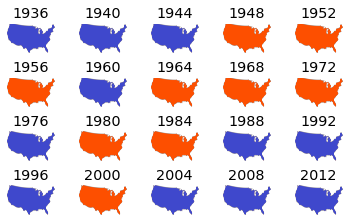

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import numpy as np

#
# Define starting and ending year for our models.
#

FIRST_YEAR = 1936
LAST_YEAR = 2016

#
# Store predictions in this array.
#

predictions_binary = []

#
# Run Logicistic Regression on each subset.
#

for i in range(FIRST_YEAR,LAST_YEAR, 4): 
        subset = dataInRange(data, i, LAST_YEAR)
        x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y = subset['party_won']
        model = LogisticRegression()
        model.fit(x,y)
        
        #
        # We have created a model, now let's get a prediction based on the 2020 data.
        #
        
        x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y_new = model.predict(x_new)
        predictions_binary.append(y_new[0])
        
#
# Debug. Print binary outcomes.
#

"""
print("Binary outcome predictions: ")
#print(predictions_binary)
"""

#
# Print the visualization showing the grid of predicted binary outcomes.
#

images = []
redMap = PIL.Image.open('Images/RedMap.png')
blueMap= PIL.Image.open('Images/BlueMap.png')

for res in predictions_binary:
    images.append(blueMap.copy() if res==0 else redMap.copy())

print('\033[1m  Predicted 2020 election results based on previous data \033[0m')
print("* each year indicates the starting year of the data used to make the prediction")
display_grid(images, [4, 5], scale=0.5, axes_pad=0.34)



These results are interesting, and worth analyzing, but there is a major problem with this approach. We want to gauge which subset of training data produces the optimal results, but we have no way of differentiating between two models that predicted the same binary outcome. No matter the actual result on Nov 3rd, almost have our models will be correct and we will have no way to distinguish which was "most" correct. We need a continuous, or at least much more varied, output. We decided from here that the electoral college vote would be a good measure, but there is a problem with this too. Electoral college votes are state level outputs based on state level inputs. We have only national data, and were unable to find reliable state level data going back any significant length of time. 



### Linear regression to predict 2020 election popular vote percentage

As such, we instead decided to predict the popular vote percentage for each major party candidate. This is an imperfect metric, since as we saw in 2016 it is not perfectly predictive of which candidate will win the election, but it is a continuous output that strongly correlates with the binary outcome of an election. 



In [33]:
#
# Store popular vote percentage predictions in these arrays.
#

predictions_r = []
predictions_d = []

#
# Get predicted popular vote percentage predictions for democrats.
#

for i in range(FIRST_YEAR,LAST_YEAR, 4): 
        subset = dataInRange(data, i, LAST_YEAR)
        x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y = subset['popular_d_percent'] 
        model = LinearRegression()
        model.fit(x,y)
        
        x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y_new = model.predict(x_new)
        predictions_d.append(y_new[0])

#
# Get predicted popular vote percentage predictions for republicans.
#

for i in range(FIRST_YEAR,LAST_YEAR, 4): 
        subset = dataInRange(data, i, LAST_YEAR)
        x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y = subset['popular_r_percent']
        model = LinearRegression()
        model.fit(x,y)
        
        x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval','current_party']]
        y_new = model.predict(x_new)
        predictions_r.append(y_new[0]) 

#
# Debug. Print predicted popular vote results for each subset.
#

#print("Popular vote predictions for republicans: ")
#print(predictions_r)

#print("Popular vote predictions for democrats: ")
#print(predictions_d)

Done


###

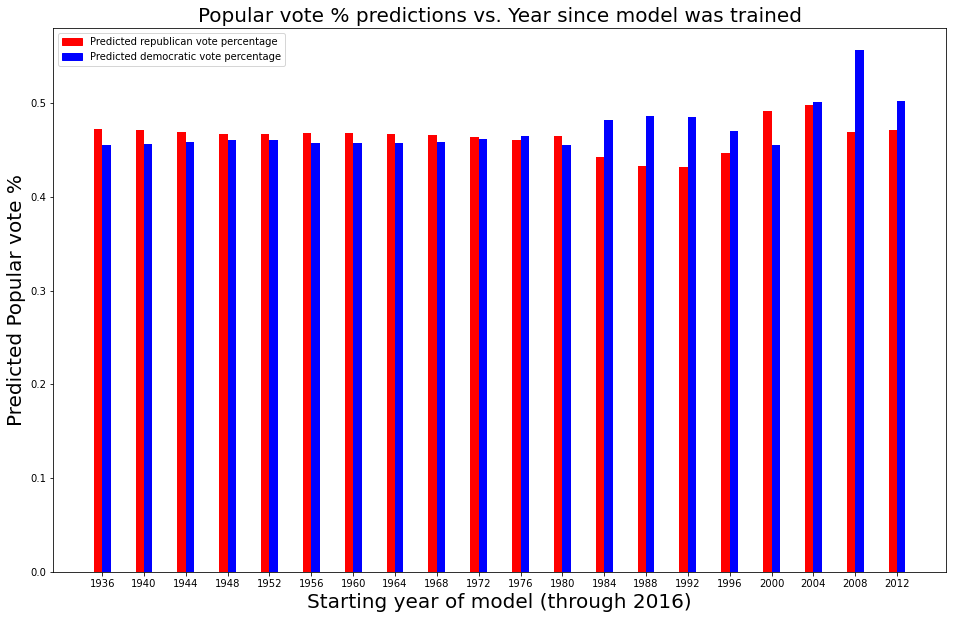

In [8]:
from matplotlib.pyplot import step, show

x = np.arange(FIRST_YEAR, LAST_YEAR, 4, dtype=int)

fig = plt.figure(figsize=(16,10))
ax = plt.subplot(111)
width = 0.8
ax.bar(x - width/2, predictions_r, width, label='Republican', color='r')
ax.bar(x + width/2, predictions_d, width, label='Democrat',   color='b')
colors = {'Predicted republican vote percentage':'red', 'Predicted democratic vote percentage':'blue'}   
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.xticks(np.arange(min(x), max(x) + 1, 4))
ax.set(ylim=[0, 0.58])
plt.xlabel('Starting year of model (through 2016)', fontsize=20)
plt.ylabel('Predicted Popular vote %', fontsize=20)
plt.title('Popular vote % predictions vs. Year since model was trained', fontsize=20)

plt.show()

### lets see how these predictions stack up against the binary predictions we got from the logistic regression. 

  Predicted 2020 election results based on popular vote. 
* each year indicates the starting year of the data used to make the prediction


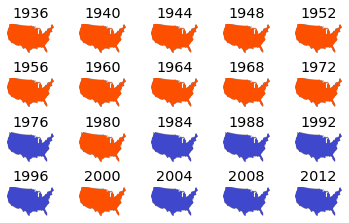

In [37]:
images = []
for res in zip(predictions_r, predictions_d):
    images.append(blueMap.copy() if res[0] < res[1] else redMap.copy())

print('\033[1m  Predicted 2020 election results based on popular vote. \033[0m')
print("* each year indicates the starting year of the data used to make the prediction")
display_grid(images, [4, 5], scale=0.5, axes_pad=0.35)

Note how the popular vote winner predictions don't align especially well with the binary outcome predictions. Let's do another visual to make this more clear. 

[]

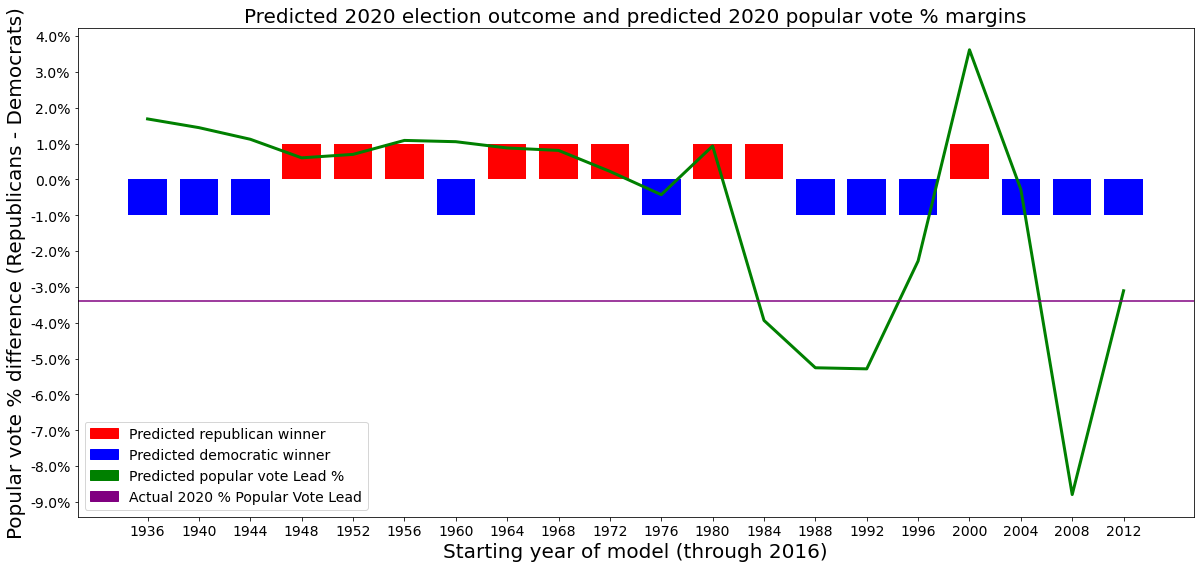

In [38]:
# Overlay the popular vote percentage difference over the binary predictions

from matplotlib.pyplot import step, show
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 14})

percentage_difference = []
for res in zip(predictions_r, predictions_d):
    percentage_difference.append((res[0] - res[1])*100)
    
#print(predictions_r)
#print(predictions_d)
tt_percentage_difference = (thisYear['popular_r_percent'].iloc[-1] - thisYear['popular_d_percent'].iloc[-1])*100
x = np.arange(FIRST_YEAR, LAST_YEAR, 4, dtype=int) #years from 1936 to 2012

republican = [1 if p > 0 else 0 for p in predictions_binary] 
democrat = [-1 if p < 1 else 0 for p in predictions_binary]

# 1 is republican, -1 is democrat
colors = {'Predicted republican winner':'red', 'Predicted democratic winner':'blue', 'Predicted popular vote Lead %':'green', 'Actual 2020 % Popular Vote Lead':'purple'}   
fig = plt.figure(figsize=(20,9))
ax = plt.subplot(111)
ax.bar(x, republican, width=3, color=colors['Predicted republican winner'])
ax.bar(x, democrat, width=3, color=colors['Predicted democratic winner'])
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.xticks(np.arange(min(x), max(x)+1, 4))
plt.yticks(np.arange(-10, 5, step=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Starting year of model (through 2016)',fontsize=20)
plt.ylabel('Popular vote % difference (Republicans - Democrats)',fontsize=20)
plt.title('Predicted 2020 election outcome and predicted 2020 popular vote % margins',fontsize=20)
line, = plt.plot(x, percentage_difference, linewidth=3.0, color='g')
line.set_label('Label via method')
plt.axhline(y=tt_percentage_difference, color='purple')
plt.plot()

#notes:
# Scale down the 1 to negative 1, (scale up to 2 but remove the 2), scale up the line so differences are more clear

Here we can see the trend over time better. Note how consistent the popular vote predictions are pre 1980, and how wildly they vary after. This is likely a consequence of the shrinking training data, which we would expect to lead to less accurate and more erratic predictions as the model overfits to specific elections. If our original prediction is correct, and older data indeed biases results to some extent, we would expect 

Now that the 2020 election is over (for our purposes we froze the data at Nov 13th and assumed Joe Biden would win), we can compare the predictions of our models to the actual results. 

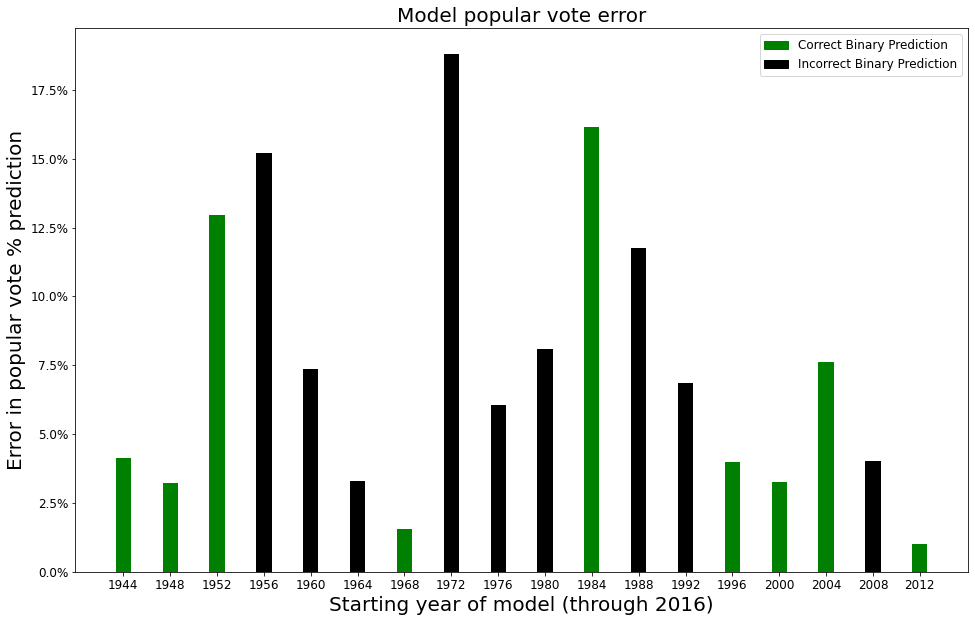

In [44]:
# insert visualization here, comparing actual vs predicted results over time
# Recommend a bar chart showing the absolute difference between the actual vs predicted popular vote,
# with each bar colored based on whether it also predicted the binary outcome correctly. 




tt_percentage_difference = thisYear['popular_r_percent'].iloc[-1] - thisYear['popular_d_percent'].iloc[-1]
pred_percentage_difference = []
for res in zip(predictions_r, predictions_d):
    pred_percentage_difference.append((res[0] - res[1]))
    
x = np.arange(FIRST_YEAR, LAST_YEAR, 4, dtype=int) #years from 1936 to 2012
y = [abs(p - tt_percentage_difference) for p in pred_percentage_difference]
y_correct = [0] * len(y)
y_incorrect = [0] * len(y)
for i in range(len(y)):
    y_correct[i] = 0
    y_incorrect[i] = 0
    if predictions_binary[i] == 0:
        y_correct[i] = y[i]
    else:
        y_incorrect[i] = y[i]
        
# Graph the data
        
fig = plt.figure(figsize=(16,10))
ax = plt.subplot(111)
#print(predictions_binary)
#print(y_correct)
#print(y_incorrect)
width = 1.3
ax.bar(x, y_correct, width, color='green')
ax.bar(x, y_incorrect, width, color='black')
colors = {'Correct Binary Prediction':'green', 'Incorrect Binary Prediction':'black'}   
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.xticks(np.arange(min(x), max(x) + 1, 4))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel('Starting year of model (through 2016)', fontsize=20)
plt.ylabel('Error in popular vote % prediction', fontsize=20)
plt.title('Model popular vote error', fontsize=20)

plt.show()
# notes:

## Results: 

There are some notable results here. We initially hypothesized that, as we approached more recent starting elections and the size of our training data got smaller, there would be an increase in the variation of the predictions. The charts above bare this out, there is indeed a large increase in the volatility of predictions as we get past ~1980. Whats especially noteworthy, however, is that the most stable predictions, which were made using the largest set of training data, are not especially accurate. They wrongly predict the popular vote margin, and are often wrong about the binary outcome as well. We somewhat anticipated this result: we only have 21 elections in our largest possible dataset, which probably isn't enough to train a robust model. 

Interestingly, the most accurate model is the one trained only on the 2012 and 2016 election. This is worth exploring further. It's possible that, because they are so close chronologically, recent elections are very predictive of future elections. If this were true, we would expect this trend to hold for more than just 2020. If not, then it could merely be a coincidence, a lucky guess. Let's see what happens if we test every past election with a model trained on the two or more previous elections. 

In [43]:
import matplotlib as mp
import colorsys
from numpy import arange

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)


plt.rcParams.update({'font.size': 12})
def num_prev_elec(num_prev, color = 'random',original = True, start_year = 1936, end_year = 2020):
    """
    num_prev is a list identifying what models to show ... please don't put a values less than 2
    original will show the original data
    end_year is inclusive'
    returns data just for debugguing
    """
    data_dict = {}
    
    scale = list(arange(0.1, 3.0 + (3.0 / float(len(num_prev) -1)), (3.0 / float(len(num_prev)-1))))
    scale.reverse()

    # add original data if needed
    if (original):
        margin = []
        data_range = dataInRange(data, start_year, end_year + 4)
        r_percent = data_range['popular_r_percent'].tolist()
        d_percent = data_range['popular_d_percent'].tolist()
        
        for r, d in zip(r_percent, d_percent):
            margin.append(abs(r-d))
        
        data_dict['original margin'] = [list(range(start_year, end_year + 4, 4)), margin]


    # go through how many previous years wanted
    for n_prev in num_prev:
        # get the absolute margin predictions

        FIRST_YEAR = start_year + (4 * n_prev)
        LAST_YEAR = end_year + 4
        margin = []
        dates = []
        for i in range(FIRST_YEAR,LAST_YEAR, 4):
            dates.append(i)
            predictions_r = []
            predictions_d = [] 
            
            thisYear = data[data['year'].between(i, i)]
            
            # train model for each of these subsets..
            subset = dataInRange(data, i - (4 * n_prev), i - 4) # --------------- -4 is because not including this year
            x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
            y = subset['popular_r_percent'] # binary outcome data from this subset of years
            model = LinearRegression()
            model.fit(x,y)
            
            ### Next, predict y from the test year data
            x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval','current_party']]
            y_new = model.predict(x_new)
            predictions_r.append(y_new[0])
            
            y = subset['popular_d_percent'] # binary outcome data from this subset of years
            model.fit(x,y)
            
            y_new = model.predict(x_new)
            predictions_d.append(y_new[0])

            # get the absolute margin
            for r, d in zip(predictions_r, predictions_d):
                margin.append(abs(abs(thisYear['popular_r_percent'] - thisYear['popular_d_percent']) - abs(r-d)))
            
        data_dict['Predicted margin using {} previous elections'.format(n_prev)] = [dates, margin]
    
    # graph the data
    fig = plt.figure(figsize=(16,10))
    i = 0
    for d in data_dict:
        x = data_dict[d][0]
        y = data_dict[d][1]
        mae = np.mean(y)
        v = np.var(y)
        mae = "{:.3f}".format(mae*100)
        v = "{:.4f}".format(v)
        # decides to choose colors
        if (color == 'random'):
            plt.scatter(x, y, label = d + ", mean error: " + mae + "%" + ", variance: " + v)
            m, b = np.polyfit(x, y, 1)
            plt.plot(x, m*x + b, linewidth=3.5)
        else:
            c = mp.colors.ColorConverter.to_rgb(color)
            new_color = [scale_lightness(c, scale[i])]
            plt.scatter(x, y, c = new_color, label = d + ", mean error: " + mae + "%" + ", variance: " + v)
            i += 1
            m, b = np.polyfit(x, y, 1)
            plt.plot(x, m*x + b, color = new_color[0], linewidth=3.5)

    
    plt.title('Accuracy of popular vote predictions when training on N previous years',fontsize=20)
    plt.ylabel('Percent error (|actual - predicted|)',fontsize=20)
    plt.xlabel('Year',fontsize=20)
    plt.xticks(list(range(start_year, end_year + 4, 4)))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.legend()
    plt.show()
    
    return data_dict


# x = num_prev_elec([2,3,4,5], original=False)

In [14]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

# variable initialization
label = widgets.Label(value="Input number of years of data to train the models, with commas in between")
text = widgets.Text(
       placeholder='2, 3',
       value = '2,3',
       description='Years back:', )
menu = widgets.Dropdown(
       options=['random','maroon', 'navy', 'green', 'purple'],
       value='random',
       description='Color:')
button = widgets.Button(description='Generate')
out = widgets.Output()

# function to be activated when clicked
def on_button_clicked(_):
    with out:
        clear_output()
        nums = [int(num) for num in text.value.split(sep = ',')]
        x = num_prev_elec(nums, color = menu.value,original=False)

# button clicked
button.on_click(on_button_clicked)

# display orginization
top_box = widgets.HBox([text, menu, button])
widgets.VBox([label,top_box, out])

### Interactive look
If you play around with the above graphic you may notice some trends. On average, using the two most recent election is not a great way to predict the next one. This doesn't necessarily mean that the accurate 2020 prediction was just a random occurence. Using only 2 elections as training data is actually significantly better than using the previous 4 or 5 elections, and approximately the same as using the previous 3 (with significantly lower variance). The more interesting trend, which we have highlighted by including regression lines, is that this method of prediction is getting more accurate over time. Predictions using recent elections are getting better all the way up to using the last 6 elections, though the trend breaks after that. Another interesting note is that using 2 or 3 previous elections is more accurate, on average, than using more elections all the way until data sets of 9 or larger, and at this point only about half the elections can be tested. 

Why do we see these trends? We are particularly interested in why the last 2-3 elections seems to be getting more predictive of future elections. This indicates that elections are getting more consistent. Put another way, there is signficantly less variation in more recent elections, at least over a short time horizon. This would seem to match lived experience. Nobody born this century has seen an election decided by more than 8 points, indeed the majority of elections this century have been decided by less than 5. Swings between elections have thus shrunk, and prior to this election the last 3 presidents had won a second term. In this way our original hypothesis has been somewhat confirmed, though not in the way we expected. It is not the case, as we had expected to find, that there is a clear trend whereby excluding older elections results in better election predictions. At the same time, however, it is clear that something *has* changed. Elections now are much more predictable, in the literal sense, than in the past. In 1960 using the previous several elections to predict the current one would have given you an error of over 10 percent, at least with our admittedly naive model. The same model, however, can predict the 2020 election with an average error of less than 5 percent. The absolute numbers are secondary to the trend.

### Where we might go from here
This is far from a definitive study. As data scientists are known to say, we need more data. 